#  Replicating Hochberg book
## Charge simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from generate_mesh import gen_mesh

import devsim as ds

In [2]:
# all units in um
w_core = 0.25
h_core = 0.22
#w_clearance = 0.5
w_clearance = 2.25
h_clearance = 0.09
w_side = 2.5
h_side = 0.22

w_contact = 1.2
h_contact = 0.2

z_size = h_clearance/5

res = h_clearance/10

#z_size = h_clearance/2

# modulator doping concentrations (1/cm^3)
conc_p = 7e17 + 1e15
conc_n = 5e17

conc_contact = 5e18

### Refinement

In [3]:
# Refinement 
# WARNING: this will result in a more expensive simulation
refine = True

### Generate 2D doping

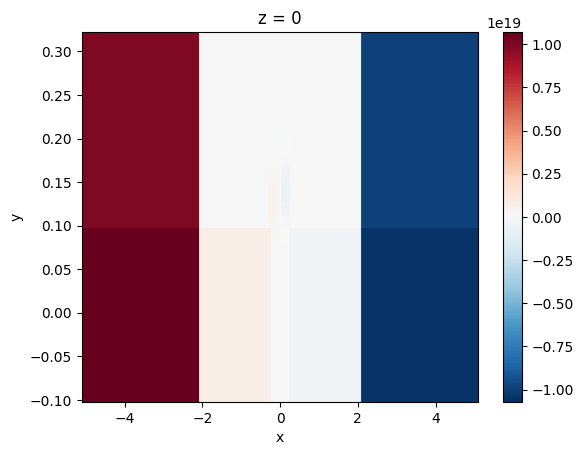

In [4]:
# get 2D doping distributions and visualize
import doping_hochberg as doping
acceptors_dist, donors_dist = doping.get_dopings_hochberg()
(acceptors_dist-donors_dist).plot(y="y")

### Create mediums

In [5]:
SiO2 = td.Medium(
    electric_spec=td.InsulatorSpec(permittivity=3.9), name="SiO2",
)

Si_2D_doping = td.Medium(
    electric_spec=td.SemiConductorSpec(
        conductivity=1,
        permittivity=11.7,
        donors=donors_dist,
        acceptors=acceptors_dist,
    ),
    name="Si_nnn",
)

aux_left = td.Medium(
    heat_spec=td.FluidSpec(),
    name="aux_left"
)

aux_right = td.Medium(
    heat_spec=td.FluidSpec(),
    name="aux_right"
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

### Generate structures

In [6]:
# create objects
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(7.5, 8, z_size)),
    medium=SiO2,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_n"
)

p_refinement = td.Structure(
    geometry=td.Box(center=(-3.8,0.1,0), size=(2.3, 0.03, z_size)),
    medium=Si_2D_doping,
    name="refinement_p"
)

n_refinement = td.Structure(
    geometry=td.Box(center=(3.8,0.1,0), size=(2.3, 0.03, z_size)),
    medium=Si_2D_doping,
    name="refinement_n"
)

wg_refinement = td.Structure(
    geometry=td.Box(center=(0,0.11,0), size=(0.4, 0.1, z_size)),
    medium=Si_2D_doping,
    name="refinement_wg"
)

side_refinement = td.Structure(
    geometry=td.Box(center=(0,0.04,0), size=(5.2, 0.02, z_size)),
    medium=Si_2D_doping,
    name="refinement_side"
)

# create a couple structs to define the contacts
contact_left = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side + w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_left,
    name="contact_left"
)

contact_right = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side - w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_right,
    name="contact_right"
)

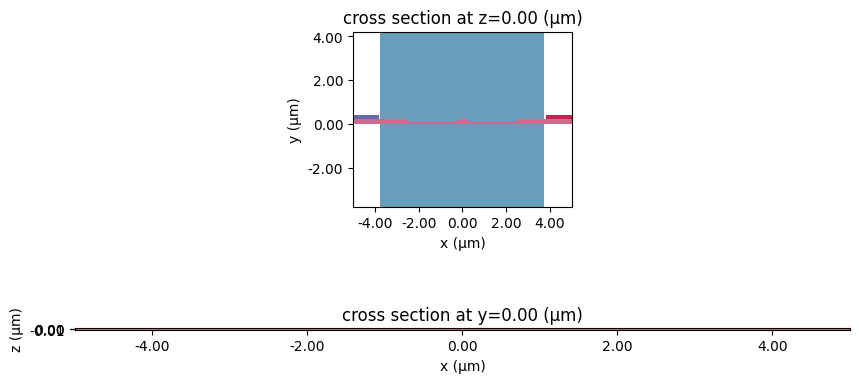

In [7]:
# create a scene with the previous structures
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n, contact_left, contact_right]

# Include refinement structures
if refine:
    all_structures = all_structures + [p_refinement, n_refinement, wg_refinement, side_refinement]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(10, 5))

scene.plot(z=0, ax=ax[0])
scene.plot(y=5e-6, ax=ax[1])
plt.show()

### BCs

In [8]:
# create BCs
voltages = list(np.linspace(-0.5, 4, 20))
voltages = [-0.5, 0, 1, 2, 3, 4]

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(voltage=0),
    placement=td.MediumMediumInterface(mediums=[aux_left.name, Si_2D_doping.name]),
)

bc_v2 = td.HeatChargeBoundarySpec(
    #condition=td.VoltageBC(voltage=0),
    condition=td.VoltageBC(voltage=voltages),
    placement=td.MediumMediumInterface(mediums=[aux_right.name, Si_2D_doping.name]),
)

boundary_conditions = [bc_v1, bc_v2]

### Monitors

In [9]:
# global monitor
charge_global_mnt = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, td.inf), name="charge_global_mnt", unstructured=True
)

# monitors around the waveguide
charge_3D_mnt = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, td.inf), name="charge_3D_mnt", unstructured=True
)

charge_monitor_z0 = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="charge_z0", unstructured=True, 
)

# Will be used later for the mode simulations
charge_monitor_z0_big = td.ChargeSimulationMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="charge_z0_big", unstructured=True, conformal=True
)

### Create simulation

In [10]:
# devsim setting 
from tidy3d import DevsimConvergenceSettings
convergence_settings = DevsimConvergenceSettings(relTol=1e5, absTol=3e3, maxIters=400, dV=10, num_subprocess=8)
if refine:
    # NOTE: for local runs, decrease the # of parallel runs since it could overflow memory
    convergence_settings = DevsimConvergenceSettings(relTol=1e5, absTol=3e3, maxIters=400, dV=10, num_subprocess=8)

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

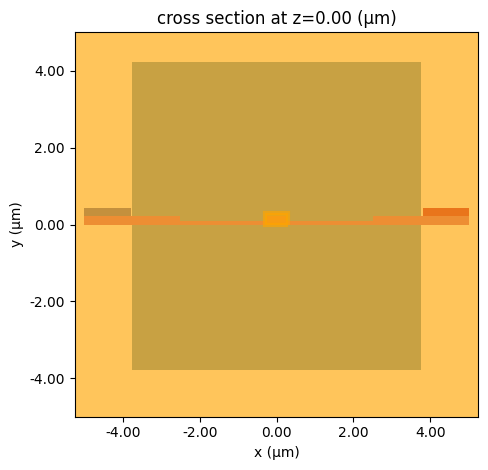

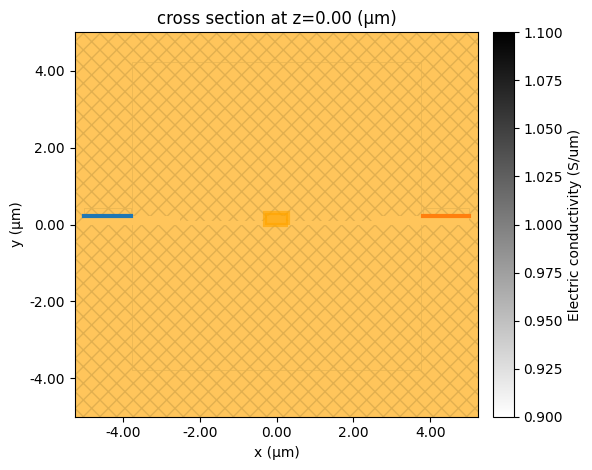

In [11]:
# mesh
mesh = td.DistanceUnstructuredGrid(dl_interface=res*0.75, dl_bulk=res*4, distance_interface=0.5*h_side,
            distance_bulk=1*h_side, relative_min_dl=0,
            non_refined_structures=[oxide.name, clearance_n.name, clearance_p.name, side_p.name, side_n.name]
        )
if refine:
    # NOTE: scrificing resolution in the waveguide region to make this a bit "cheaper"
    mesh = td.DistanceUnstructuredGrid(dl_interface=res*1.15, dl_bulk=res*4, distance_interface=0.2*h_side,
                distance_bulk=1*h_side, relative_min_dl=0,
                non_refined_structures=[oxide.name, clearance_n.name, clearance_p.name, side_p.name, side_n.name, core_p.name, core_n.name]
            )

# build heat simulation object
heat_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[charge_global_mnt, charge_3D_mnt, charge_monitor_z0, charge_monitor_z0_big],
    devsim_settings=[convergence_settings],
    center=(0,0,0),
    size=(10.5,10,5),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    #grid_spec=td.UniformUnstructuredGrid(dl=res, relative_min_dl=3e-7),
    symmetry=(0, 0, 0)
    )
heat_sim.plot(z=0)
heat_sim.plot_property(z=0, property="electric_conductivity")

### Run pipeline

In [12]:
%matplotlib inline
#from run_drift import run_drift
#devsim_data = run_drift(heat_sim)

# run on server
from tidy3d import web
devsim_data=web.run(heat_sim, task_name="test_prash", solver_version="dd-devsim-0.0.0", path="charge_web.hdf5")

11:45:55 CET Created task 'test_prash' with task_id                             
             'he-935d8b07-c5dd-415f-b32e-e00827056ee0' and task_type 'HEAT'.

             Tidy3D's Heat solver is currently in the beta stage. Cost of Heat  
             simulations is subject to change in the future.

             View task using web UI at                                          
             ]8;id=300729;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=182262;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\taskId]8;;\]8;id=300729;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\=]8;;\]8;id=48757;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\he]8;;\]8;id=300729;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\-935d8b07-c5dd-]8;;\
             ]8;id=300729;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\415f-b32e-e00827056ee0']8;;\.

Output()

11:45:59 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:46:22 CET status = preprocess

11:57:26 CET status = postprocess

12:02:56 CET status = success

             Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             status = success

             View simulation result at                                          
             ]8;id=937145;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=772767;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\taskId]8;;\]8;id=937145;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\=]8;;\]8;id=979662;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\he]8;;\]8;id=937145;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\-935d8b07-c5dd-]8;;\
             ]8;id=937145;https://tidy3d.simulation.cloud/workbench?taskId=he-935d8b07-c5dd-415f-b32e-e00827056ee0\415f-b32e-e00827056ee0']8;;\.

Output()

12:03:05 CET loading simulation from charge_web.hdf5

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

### Post-process Charge simmulation

(-0.5, 0.0, 1.0, 2.0, 3.0, 4.0)


/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


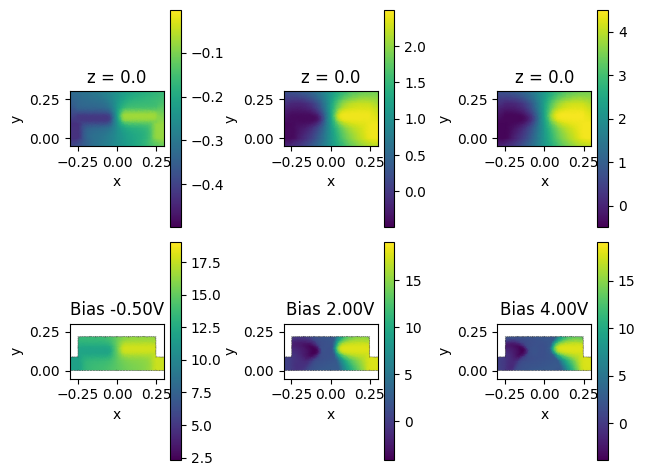

In [13]:
#devsim_data[volt_y0_mnt.name].voltage.sel(z=0).plot(grid=False)
print(devsim_data[charge_monitor_z0.name].data_series.parameter_array)

indices = [0]
indices.append(int(np.ceil(devsim_data[charge_monitor_z0.name].data_series.num_fields_saved/2)))
indices.append(int(np.ceil(devsim_data[charge_monitor_z0.name].data_series.num_fields_saved-1)))

series = devsim_data[charge_monitor_z0.name].data_series
sets_to_plot = [[], []]
if devsim_data[charge_monitor_z0.name].data_series.num_fields_saved > 2:
    fig, ax = plt.subplots(2, 3)
    for n, index in enumerate(indices):
        mnt_name = charge_monitor_z0_big.name
        mnt_name = charge_global_mnt.name
        
        sets_to_plot[0].append(
            devsim_data[mnt_name].data_series.get_field("Potential", index).sel(z=0)
        )
        sets_to_plot[0][n].plot(ax=ax[0][n], grid=False)
        ax[0][n].set_xlim((-0.3, 0.3))
        ax[0][n].set_ylim((-0.05, 0.3))
        sets_to_plot[1].append(
            np.log10(devsim_data[mnt_name].data_series.get_field("Electrons", index).sel(z=0))
        )
        sets_to_plot[1][n].plot(ax=ax[1][n], grid=False)
        ax[1][n].set_title("Bias {0:0.2f}V".format(series.parameter_array[index]))
        ax[1][n].set_xlim((-0.3, 0.3))
        ax[1][n].set_ylim((-0.05, 0.3))

plt.tight_layout()

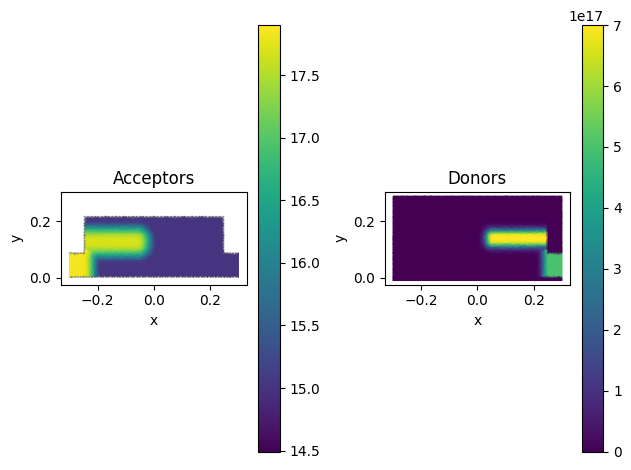

In [14]:
# visualize doping in monitor area
# NOTE: doping has been passed as net doping to 'acceptors', which means donors=0
monitor_doping = []

fig, ax = plt.subplots(1, 2)
mnt_name = charge_monitor_z0.name

monitor_doping.append(
    np.log10(np.abs(devsim_data[mnt_name].data_series.get_doping("Acceptors")))
)
monitor_doping[0].plot(ax=ax[0], grid=False)
ax[0].set_title("Acceptors")

monitor_doping.append(
    devsim_data[mnt_name].data_series.get_doping("Donors")
)
monitor_doping[1].plot(ax=ax[1], grid=False)
ax[1].set_title("Donors")

plt.tight_layout()

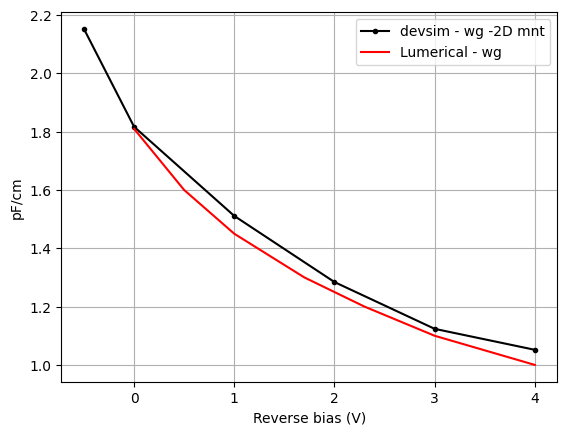

In [15]:
# capacitance from monitor - waveguide area
c_lumerical_wg_in_SiO2 = np.array([0.181, 0.16, 0.145, 0.13, 0.12, 0.11, 0.1])
b_lumerical_wg_in_SiO2 = np.array([0,     0.5,   1,    1.7,  2.3,  3,     4])


mnt_v = np.array(devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].coords["Voltage (V)"].data)
mnt_ce = np.array(devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].data)
mnt_ch = np.array(devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_h"].data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10, 'k.-', label="devsim - wg -2D mnt")
plt.plot(b_lumerical_wg_in_SiO2, c_lumerical_wg_in_SiO2*10, 'r-', label="Lumerical - wg")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()
#devsim_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].plot()

### Comparison against experimental data

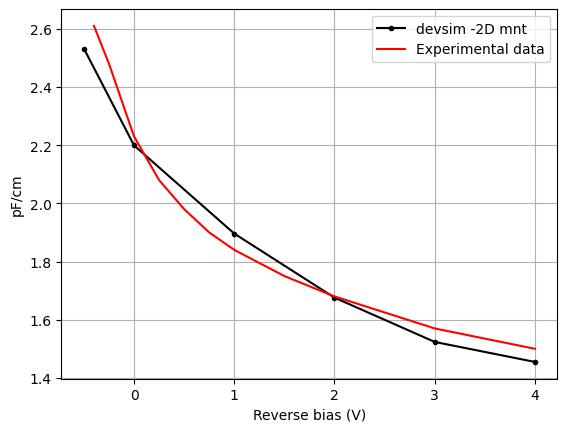

In [16]:
# capacitance from monitor - waveguide area
CV_baehrjones = [
    [-0.4, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4],
    [0.261, 0.248, 0.223, 0.208, 0.198, 0.190, 0.184, 0.175, 0.168, 0.157, 0.150]]


mnt_v = np.array(devsim_data[charge_monitor_z0_big.name].capacitance_curve["cv_curve_e"].coords["Voltage (V)"].data)
mnt_ce = np.array(devsim_data[charge_monitor_z0_big.name].capacitance_curve["cv_curve_e"].data)
mnt_ch = np.array(devsim_data[charge_monitor_z0_big.name].capacitance_curve["cv_curve_h"].data)

#mnt_ce = np.array(devsim_data[charge_global_mnt.name].capacitance_curve["cv_curve_e"].data)
#mnt_ch = np.array(devsim_data[charge_global_mnt.name].capacitance_curve["cv_curve_h"].data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10 , 'k.-', label="devsim -2D mnt")
plt.plot(CV_baehrjones[0], np.array(CV_baehrjones[1])*10, 'r-', label="Experimental data")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()

## Generate Charge-dependent perturbation material

In [17]:
# define first the range of frequencies of interest

wvl_um = 1.55
freq0 = td.C_0 / wvl_um

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

# max/min wavelengths
print(np.max(wvls), np.min(wvls))

1.5816326530612244 1.519607843137255


In [18]:
si = td.material_library['cSi']['Palik_Lossless']
SiO2_lib = td.material_library['SiO2']['Palik_Lossy']

n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)

In [19]:
# Import material data from Lumerical (see notebook "Lumerical_material_fitting.ipynt")
#Si_lumerical = td.PoleResidue.from_file("fitted_si.json")
#SiO2_lumerical = td.PoleResidue.from_file("fitted_sio2.json")

# using fitted Lumerical material properties
#n_si, k_si = Si_lumerical.nk_model(frequency=td.C_0 / wvl_um)

#print(si.eps_comp(row=0, col=0, frequency=td.C_0 / 1.55))
#print(Si_lumerical.eps_comp(row=0, col=0, frequency=td.C_0 / 1.55))

In [20]:
ne_coeff = -5.4e-22 * 1.1
ne_pow = 1.011

nh_coeff = -1.53e-18 * 1.1
nh_pow = 0.838

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21 * 1.1
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20 * 1.1
kh_pow = 1.109

In [21]:
Ne_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))
Nh_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

dn_mesh = ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
dk_mesh = ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

In [22]:
si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

In [23]:
dn_data = td.ChargeDataArray(dn_mesh, coords=dict(n=Ne_range, p=Nh_range))
dk_data = td.ChargeDataArray(dk_mesh, coords=dict(n=Ne_range, p=Nh_range))

n_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
k_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)

n_si_perturbation = td.ParameterPerturbation(
    charge=n_si_charge,
)

k_si_perturbation = td.ParameterPerturbation(
    charge=k_si_charge,
)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=n_si_perturbation,
        delta_k=k_si_perturbation,
        freq=freq0,
    )
)

## Create mode simulation

### Regenerate structures with larger span and perturbed material

In [24]:
# create objects
span = 2*wvl_um
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(7, 4, span)),
    medium=SiO2_lib,
    #medium=SiO2_lumerical,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, span)),
    medium=si_perturb,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, span)),
    medium=si_perturb,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, span)),
    medium=si_perturb,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, span)),
    medium=si_perturb,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, span)),
    medium=si_perturb,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, span)),
    medium=si_perturb,
    name="side_n"
)

### Recreate scene

In [25]:
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n]
all_structures = [core_p, core_n, clearance_n, clearance_p, side_p, side_n]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)

### Define mode source

In [26]:
buffer = 1*wvl_um

port_center = (0,h_core,-span/2)
port_size = (5, 5, 0)

### Create simulation

In [27]:
sim_size = (10+buffer, 10+buffer, span+3*buffer)
sim_size = (13+buffer, 10+buffer, span)
bc_spec = td.BoundarySpec(
    x = td.Boundary.pml(num_layers=20),
    y = td.Boundary.pml(num_layers=30),
    #z = td.Boundary.pml(num_layers=30),
    z = td.Boundary.periodic(),
)

sim = td.Simulation(
    center=(0,0,0),
    size=sim_size,
    medium=td.Medium(permittivity=3.9),
    structures=scene.structures,
    run_time=6e-12,
    boundary_spec=bc_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=wvl_um)
)

12:03:17 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

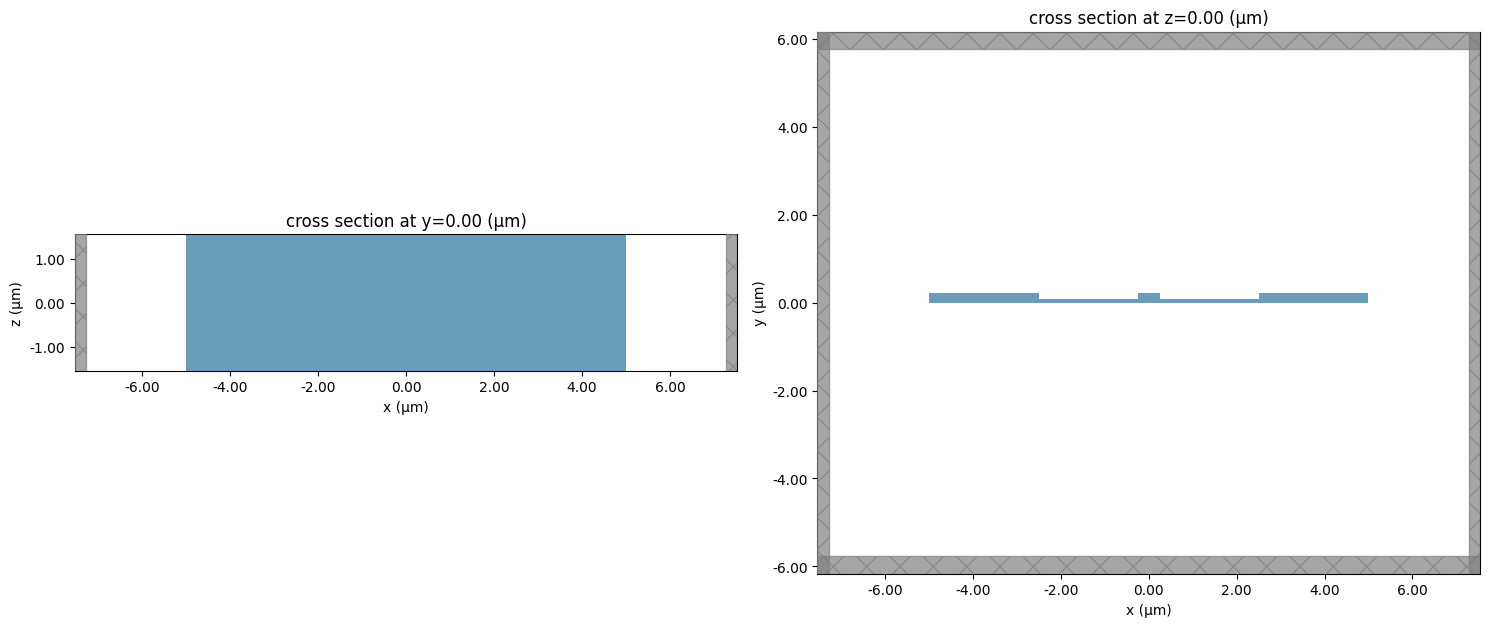

In [28]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
sim.plot(y=sim.center[1], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

In [29]:
def apply_charge(devsim_data):
    perturbed_sims = []
    for n, v in enumerate(devsim_data[charge_global_mnt.name].data_series.parameter_array):
        #e_data = devsim_data[charge_global_mnt.name].data_series.get_field("Electrons", n).sel(z=0)
        #h_data = devsim_data[charge_global_mnt.name].data_series.get_field("Holes", n).sel(z=0)
        e_data = devsim_data[charge_monitor_z0_big.name].data_series.get_field("Electrons", n)
        h_data = devsim_data[charge_monitor_z0_big.name].data_series.get_field("Holes", n)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data, 
                hole_density=h_data,
            )
        )
    return perturbed_sims

perturbed_sims = apply_charge(devsim_data)

12:03:18 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

12:03:19 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

12:03:20 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

12:03:21 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

12:03:22 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

12:03:23 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

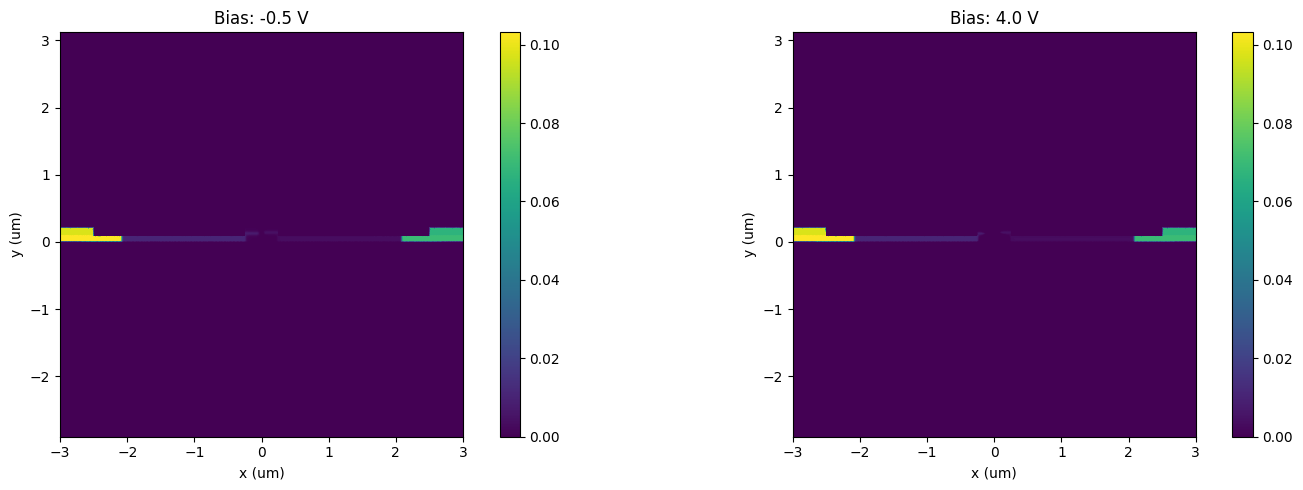

In [30]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

sampling_region = td.Box(center=(0, h_core/2, 0), size=(6, 6, 0))
eps_undoped = sim.epsilon(box=sampling_region).isel(z=0, drop=True)

for ax_ind, ind in enumerate([0, len(voltages)-1]):
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).isel(z=0,  drop=True)
    eps_doped = eps_doped.interp(x=eps_undoped.x, y=eps_undoped.y)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="x", ax=ax[ax_ind])
    
    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

### Waveguide mode analysis

In [31]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run_batch as run_mode_batch

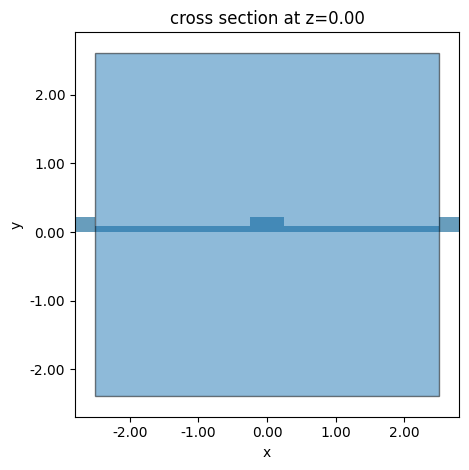

In [32]:
mode_plane = td.Box(center=(0, h_core / 2, 0), size=port_size)

# visualize
ax = sim.plot(z = 0)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

In [33]:
mode_solvers = []
for psim in perturbed_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers.append(ms)

In [34]:
#ms_data = run_mode_batch(mode_solvers=mode_solvers, max_workers=1)
ms_data = run_mode_batch(mode_solvers=mode_solvers)

             Running a batch of 6 mode solvers.                                 
             

Output()

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

12:05:49 CET A batch of `ModeSolver` tasks completed successfully!

### local run
import sys
sys.path.append("/home/marc/Documents/src/tidy3d-core")
from tidy3d_backend.mode import BackendModeSolver
ms_data = []
for psim in perturbed_sims:
    ms = BackendModeSolver(
        eig_solver="auto",
        thread_size=20,
        thread_size_excluded_parallel_solver=20,
        simulation=psim,
        plane=mode_plane,
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
        freqs=freqs,
        subpixel_scheme=0,
        #colocate=colocate,
        #direction=direction,
    )
    ms_data.append(ms.solve())

In [35]:
ms_data[0].to_dataframe()
print(freq0)
print(freqs[3])

193414489032258.06
189662247945032.25


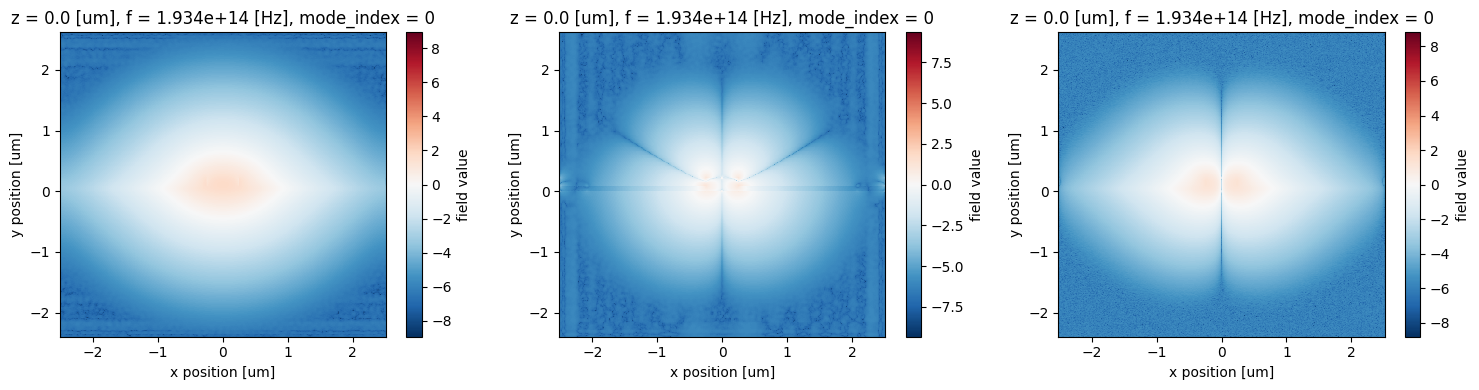

In [36]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
np.log10(np.abs(ms_data[0].Ex.sel(z=0, f=freq0))).plot(ax=ax[0], x="x")
np.log10(np.abs(ms_data[0].Ey.sel(z=0, f=freq0))).plot(ax=ax[1], x="x")
np.log10(np.abs(ms_data[0].Ez.sel(z=0, f=freq0))).plot(ax=ax[2], x="x")
plt.tight_layout()

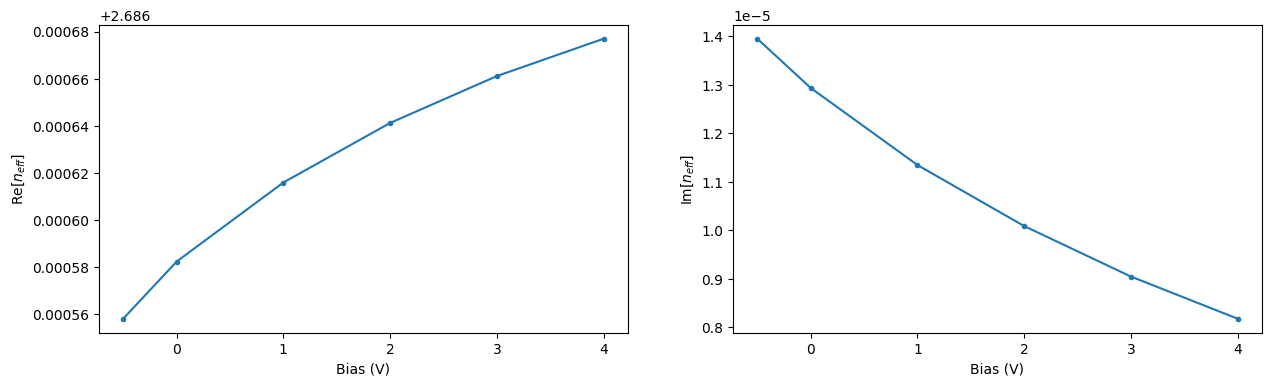

In [37]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_data]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, np.real(n_eff_freq0), ".-")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel("Re[$n_{eff}$]")

ax[1].plot(voltages, np.imag(n_eff_freq0), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Im[$n_{eff}$]")

plt.show()

### Relative phase change

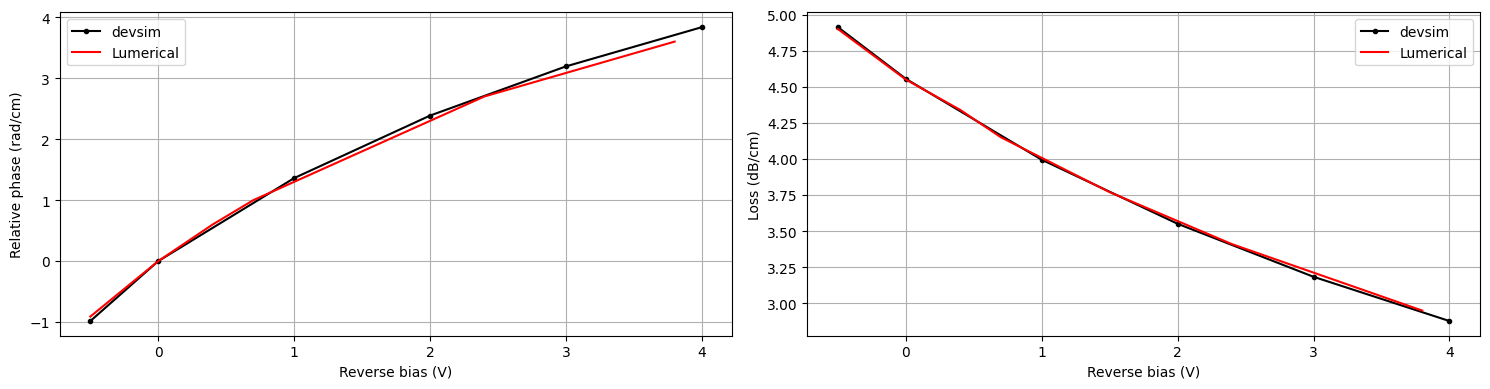

In [38]:
ind_V0 = 1
delta_neff = np.real(n_eff_freq0 - n_eff_freq0[ind_V0])
rel_phase_change = 2*np.pi*delta_neff/wvl_um * 1e4
alpha_dB_cm = 10*4*np.pi*np.imag(n_eff_freq0)/wvl_um*1e4*np.log10(np.exp(1))

# lumerical results
v_lumerical = [-0.5, 0, 0.4, 0.7, 1.5, 2.4, 3.8]
pc_lumerical=[-0.91, 0, 0.6, 1,   1.8, 2.7, 3.6]
loss_lumerical = [4.9, 4.55, 4.34, 4.15, 3.77, 3.41, 2.95]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, rel_phase_change, 'k.-', label="devsim")
ax[0].plot(v_lumerical, pc_lumerical, 'r-', label="Lumerical")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(voltages, alpha_dB_cm, 'k.-', label="devsim")
ax[1].plot(v_lumerical, loss_lumerical, 'r-', label="Lumerical")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()